In [1]:
import bempp.api
import numpy as np
import scipy
import math
import time
import scipy.linalg 
import scipy.linalg.interpolative as sli
%matplotlib inline
from matplotlib import pyplot as plt

from bempp.api.assembly.blocked_operator import BlockedOperator
from numpy.linalg import slogdet
#bempp.api.enable_console_logging()

In [2]:
def get_box(nx, ny, mat, nboxes, n):
    """Return the content of a given box"""
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return mat[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [3]:
def get_con_box(i,mat,nboxes,n):
    BB = mat[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(mat[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [4]:
def L(i,k,mat,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,mat,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,mat,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [5]:
def index_set(k,mat,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L(i,k,mat,nboxes,n)[1][0:k])
    return l

In [6]:
def S(k,mat,nboxes,n):
    ll = index_set(k,mat,nboxes,n)
    mat__ = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ = get_box(i,j,mat,nboxes,n)[ll[i],:]
                mat__[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat__

In [7]:
def R(i,k,mat,nboxes,n):
    RR = np.transpose(L(i,k,mat,nboxes,n)[0])
    return RR

In [8]:
def new_S(k,mat,nboxes,n):
    mat_ = S(k,mat,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,mat,nboxes,n) @ np.linalg.inv(get_box(i,i,mat,nboxes,n)) @ L(i,k,mat,nboxes,n)[0])
    return mat_

In [9]:
def logdet_(k,mat,nboxes,n):
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S(k,mat,nboxes,n))
    for i in range(k*nboxes):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,mat,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R(i,k,mat,nboxes,n)@np.linalg.inv(get_box(i,i,mat,nboxes,n)) @L(i,k,mat,nboxes,n)[0] )
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
    return a1 + a2 + a3

In [10]:
NZ = 15
lower_bd = 0.5  # lower bound of Z
upper_bd = 4.0  # upper bound of Z
surf_dist = np.linspace(lower_bd, upper_bd, NZ)

Nk = 15
lbound = .05    # lower bound of k in ik
ubound = 4      # upper bound of k in ik
quad_points = np.linspace(np.exp(-ubound), np.exp(-lbound), Nk)
result_k = np.empty(Nk, dtype='float64')
result_rk = np.empty(Nk, dtype='float64')


Casimir_energy = np.empty(NZ, dtype='float64')
Casimir_energy_appro = np.empty(NZ, dtype='float64')

h = .2   # size of the mesh (element)

In [11]:
# Two unit spheres' case
for index1, point1 in enumerate(surf_dist):
    
    center1 = ((point1/2) + 1, 0, 0)
    center2 = (-((point1/2) + 1), 0, 0)

    sphere1 = bempp.api.shapes.sphere(h=h, origin=center1)
    sphere2 = bempp.api.shapes.sphere(h=h, origin=center2)
    
    rwg1 = bempp.api.function_space(sphere1, "RWG", 0)
    rwg2 = bempp.api.function_space(sphere2, "RWG", 0)

    snc1 = bempp.api.function_space(sphere1, "SNC", 0)
    snc2 = bempp.api.function_space(sphere2, "SNC", 0)
    
    for index2, point2 in enumerate(quad_points):
    
        wavenumber = -1j * np.log(point2)

        op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg1, snc1, wavenumber)
        op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg2, snc2, wavenumber)
        op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg2, snc2, wavenumber)
        op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg1, snc1, wavenumber)

        blocked_op = BlockedOperator(2, 2)
        blocked_op[0, 0] = op11
        blocked_op[0, 1] = op12
        blocked_op[1, 0] = op21
        blocked_op[1, 1] = op22

        blocked_diag = BlockedOperator(2, 2)
        blocked_diag[0, 0] = op11
        blocked_diag[1, 1] = op22

        mat = np.real(bempp.api.as_matrix(blocked_op.weak_form()))
        mat2 = np.real(bempp.api.as_matrix(blocked_diag.weak_form()))
        combined = np.linalg.inv(mat2).dot(mat)
        sign, logdet = slogdet(combined)
        result_k[index2] = logdet
        
        n = combined.shape[0]
        nboxes = 33
        size = n//nboxes
        k = 20
        result_rk[index2] = logdet_(k,combined,nboxes,n)
        
    Casimir_energy[index1] = np.trapz(-result_k / surf_dist, surf_dist) / (2 * np.pi)
    Casimir_energy_appro[index1] = np.trapz(-result_rk / surf_dist, surf_dist) / (2 * np.pi)

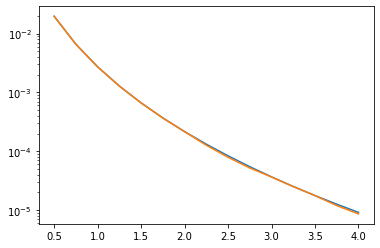

In [12]:
plt.semilogy(surf_dist,Casimir_energy)
plt.semilogy(surf_dist,Casimir_energy_appro)

In [13]:
relative_error = np.empty(NZ,dtype='float64')
for i in range(NZ):
    relative_error[i] = (Casimir_energy[i]-Casimir_energy_appro[i])/Casimir_energy[i]

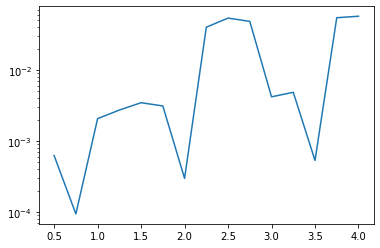

In [14]:
plt.semilogy(surf_dist, abs(relative_error))

In [15]:
relative_error

array([ 6.23428266e-04,  9.40067239e-05,  2.06947469e-03,  2.73428896e-03,
        3.46774861e-03,  3.12117383e-03, -2.98120663e-04,  4.01753551e-02,
        5.40242561e-02,  4.85559881e-02,  4.20055173e-03,  4.86049730e-03,
        5.33446791e-04,  5.46808252e-02,  5.73566431e-02])